In [33]:
import numpy as np 
from skimage.util.shape import view_as_windows
import tensorflow as tf
import scipy
from library import hrNet
import numpy as np
import matplotlib.pyplot as plt
from rgb2yuv_yuv2rgb import YUV2RGB
from auxFunctions import readFrames, image_preprocess
from yuv420 import readYUV420Range
import lpips
import torch

In [2]:
class lpipsClass():
    def __init__(self):
        self.loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

    def lpipsLossFunc(self, x, y):
        x, y = torch.tensor(x), torch.tensor(y)
        d = self.loss_fn_vgg(x, y)
        return d

In [3]:
def deconstruct(arr, patchSize=192, windowType='barthann'):
    inputHeight, inputWidth = arr.shape[0], arr.shape[1]

    #PAD HEIGHT AND WIDTH TO MULTIPLE OF PATCHSIZE
    nearestHeight = 0 
    nearestWidth = 0 
    cnt = 0 
    while nearestWidth < inputWidth:
        nearestWidth = cnt * patchSize
        cnt += 1 
    cnt = 0 
    while nearestHeight < inputHeight:
        nearestHeight = cnt * patchSize
        cnt += 1 
    toPadX, toPadY = ((nearestWidth - inputWidth + patchSize)//2), (nearestHeight - inputHeight + patchSize//2)
    arr = np.pad(arr, ((toPadY, toPadY),(toPadX, toPadX), (0,0)), 'edge')
    arr = view_as_windows(arr, (patchSize, patchSize, 3), step=patchSize//2)
    reformed_shape = arr.shape 
    arr = np.reshape(arr, (-1, patchSize, patchSize, 3))
    # Variable "arr" are N * patchSize * patchSize * 3 patches with some overlap 
    return arr

In [4]:
# THe outside code to pass into the above function
vidFilePath = 'Dataset/'
vidFileName = 'DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSSLESS-thedigitaltheater_3_AV1_CRF13_.yuv'
vidResolution = (1920,1080)
vidNumFrames = 120

artifactReductionModel = hrNet(2, [32, 64, 128, 256], 5).model()
# Loads in the current weights, will be changed later after training on dataset
artifactReductionModel.load_weights('modelWeights/287_HRNET.h5')

In [5]:
frame_tmin1,frame_t,frame_tplus1 = readFrames(vidFilePath+vidFileName,vidResolution,113,vidNumFrames)

In [7]:
window_tmin1 = deconstruct(frame_tmin1,192)
window_t = deconstruct(frame_t,192)
window_tplus1 = deconstruct(frame_tplus1,192)

In [8]:
inputPatches = np.concatenate((window_tmin1, window_t, window_tplus1), axis=-1)
inputPatches = np.expand_dims(inputPatches, axis=0)
numPatches = inputPatches.shape[1]
inputPatches = tf.convert_to_tensor(inputPatches)

In [9]:
outputPatches = np.empty((1,numPatches,192,192,3))

In [10]:
for i in range(numPatches):
    outputPatches[:,i,:,:,:] = artifactReductionModel(inputPatches[:,i,:,:,:],training=False)

In [11]:
def reconstruct(arr_actual, arr, patchSize=192, windowType='barthann'):
    inputHeight, inputWidth = arr.shape[0], arr.shape[1]

    #PAD HEIGHT AND WIDTH TO MULTIPLE OF PATCHSIZE
    nearestHeight = 0 
    nearestWidth = 0 
    cnt = 0 
    while nearestWidth < inputWidth:
        nearestWidth = cnt * patchSize
        cnt += 1 
    cnt = 0 
    while nearestHeight < inputHeight:
        nearestHeight = cnt * patchSize
        cnt += 1 
    toPadX, toPadY = ((nearestWidth - inputWidth + patchSize)//2), (nearestHeight - inputHeight + patchSize//2)
    arr = np.pad(arr, ((toPadY, toPadY),(toPadX, toPadX), (0,0)), 'edge')
    arr = view_as_windows(arr, (patchSize, patchSize, 3), step=patchSize//2)
    reformed_shape = arr.shape 
    arr = np.reshape(arr, (-1, patchSize, patchSize, 3))

    if windowType == 'bartlett':
        window1d = scipy.signal.windows.bartlett(patchSize)
    elif windowType == 'blackman':
        window1d = scipy.signal.windows.bartlett(patchSize)
    if windowType == 'barthann':
        window1d = scipy.signal.windows.barthann(patchSize)
    window2d = np.reshape((np.outer(window1d, window1d)),(patchSize, patchSize, 1))
    arr_actual = arr_actual * window2d
    arr_actual = np.reshape(arr_actual, reformed_shape)
    outputArr = np.zeros((inputHeight+2*toPadY, inputWidth+2*toPadX, 3))
    for y in range(reformed_shape[0]):
        for x in range(reformed_shape[1]):
            currentSlice = np.s_[y*patchSize//2:(y*patchSize//2) + patchSize, x*patchSize//2:(x*patchSize//2) + patchSize, :]
            outputArr[currentSlice] = outputArr[currentSlice] + arr_actual[y, x, 0]
    outputArr = outputArr[toPadY:-toPadY, toPadX:-toPadX, :]
    return outputArr

In [12]:
outputFrame = reconstruct(outputPatches[0],frame_t,192)

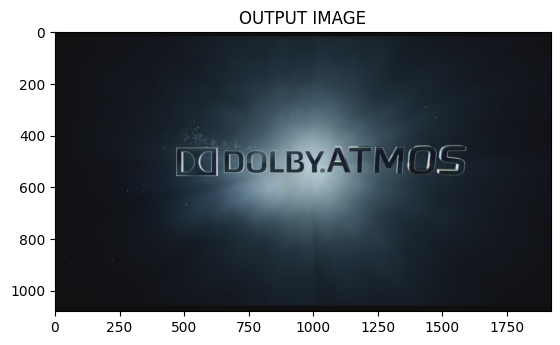

In [25]:
plt.imshow(outputFrame/255.0)
plt.title("OUTPUT IMAGE")
plt.show()
plt.imsave("Output/OutputImage.png",outputFrame/255.0)

In [18]:
vidFileName = 'DOLBY_ATMOS_UNFOLD_2_FEEL_EVERY_DIMENSION_LOSSLESS-thedigitaltheater_3.yuv'
_,frame_t_ref,_ = readFrames(vidFilePath+vidFileName,vidResolution,113,vidNumFrames)

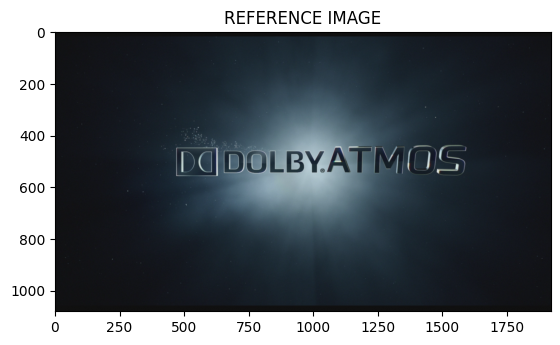

In [19]:
plt.imshow(frame_t_ref/255.0)
plt.title("REFERENCE IMAGE")
plt.show()
plt.imsave("Output/ReferenceImage.png",frame_t_ref/255.0)

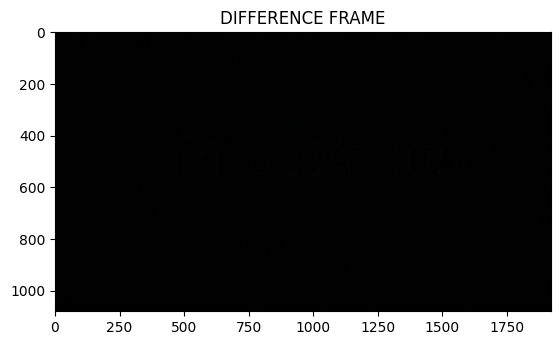

In [20]:
# The Difference Frame
difference_frame = np.absolute(np.subtract(outputFrame,frame_t_ref))
plt.imshow((difference_frame)/255.0)
plt.title("DIFFERENCE FRAME")
plt.show()

In [21]:
# Some image processing required to compute LPIPS (which uses Pytorch)
# the original frame
img0 = image_preprocess(frame_t_ref)
img0 = np.expand_dims(img0,axis=0)
img0 = np.moveaxis(img0,-1,1)
img0 = np.float32(img0)
# the restored frame
img1 = image_preprocess(outputFrame)
img1 = np.expand_dims(img1,axis=0)
img1 = np.moveaxis(img1,-1,1)
img1 = np.float32(img1)
# Converting from numpy to pytorch
img0 = torch.tensor(img0)
img1 = torch.tensor(img1)

In [22]:
# Creates an instance of LPIPS
lpipsInst = lpipsClass()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [23]:
#Outputs the LPIPS metric evaluation for the original frame t and the restored frame (the two inputs)
dist = lpipsInst.lpipsLossFunc(img0, img1)
print(dist.item())

C:\Users\victo\AppData\Local\Temp\ipykernel_18456\3715477040.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x), torch.tensor(y)


0.3326021730899811
